In [17]:
import pandas as pd
import pymongo

a = 1
print("hello")

hello


In [18]:
uri = pymongo.MongoClient()
db = uri["hjxh_express_match"]
coll = db["detail"]

In [19]:
data = pd.DataFrame(
    list(coll.find(
        {
            "weight_erp": {"$exists": True},
            "weight_trd": {"$exists": True},
        },
        {
            "weight_erp": 1,
            "weight_trd": 1,
            "file_name_erp": 1,
            "file_name_trd": 1,
        },
        limit=100))
)
print(data.shape)

(100, 5)


In [20]:

data["weight_diff_pct"] = data.weight_trd / data.weight_erp - 1

In [21]:
data["weight_qualified"] = data.weight_diff_pct < 0.1

In [22]:
data

,_id,file_name_trd,weight_trd,file_name_erp,weight_erp,weight_diff_pct,weight_qualified
0,YT6051821481165,trd_2021-11_圆通.xlsx,3.71,erp_20211217_销售出库单_李佳欣_1.csv,3.62,0.024862,True
1,YT6056690304522,trd_2021-11_圆通.xlsx,3.72,erp_11月旺店通数据.csv,4.00,-0.070000,True
2,YT6056690316413,trd_2021-11_圆通.xlsx,3.72,erp_11月旺店通数据.csv,4.06,-0.083744,True
3,YT6056690316515,trd_2021-11_圆通.xlsx,3.72,erp_11月旺店通数据.csv,4.06,-0.083744,True
4,YT6056690316631,trd_2021-11_圆通.xlsx,3.72,erp_11月旺店通数据.csv,4.06,-0.083744,True
...,...,...,...,...,...,...,...
95,YT6056696846888,trd_2021-11_圆通.xlsx,3.72,erp_11月旺店通数据.csv,4.06,-0.083744,True
96,YT6056696846941,trd_2021-11_圆通.xlsx,3.72,erp_11月旺店通数据.csv,4.06,-0.083744,True
97,YT6056696857077,trd_2021-11_圆通.xlsx,3.72,erp_11月旺店通数据.csv,4.02,-0.074627,True
98,YT6056696884257,trd_2021-11_圆通.xlsx,3.72,erp_11月旺店通数据.csv,4.06,-0.083744,True


In [23]:
data.weight_qualified.all()

True

AttributeError: 'Rectangle' object has no property 'column'

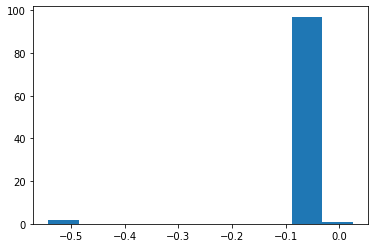

In [28]:
data.weight_diff_pct.hist()